In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-16 20:58:52.570418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 20:58:58.724599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features_dummy.csv", index_col=0)
molecule_features_dummy = pd.read_csv("./data/mol_dummy_rdkit.csv", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)
mol_pathway = pd.read_csv("./data/molecule_features_dummy.csv", index_col=0).astype('int8')

In [3]:
molecule_features_dummy = pd.concat([mol_pathway, molecule_features_dummy], axis=1)

In [4]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 23126, Edges: 40000

 Node types:
  molecule: [12759]
    Features: float32 vector, length 1638
    Edge types: molecule-present_in->species
  species: [10367]
    Features: float32 vector, length 4974
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [20000]
        Weights: all 1 (default)
        Features: none


In [5]:
batch_size = 200 #default: 200
epochs = 15 #default: 20
# Use 80% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2
num_samples = [4]
num_workers = multiprocessing.cpu_count()-2

In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.3, method="global", keep_connected=False, edge_label="present_in"
)

Network has 20000 edges of type present_in
Network has 20000 edges of type present_in
** Sampled 6000 positive and 6000 negative edges. **


In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.3, method="global", keep_connected=False, edge_label="present_in"
)

Network has 14000 edges of type present_in
Network has 14000 edges of type present_in
** Sampled 4200 positive and 4200 negative edges. **


In [8]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 23126, Edges: 29800

 Node types:
  molecule: [12759]
    Features: float32 vector, length 1638
    Edge types: molecule-present_in->species
  species: [10367]
    Features: float32 vector, length 4974
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [9800]
        Weights: all 1 (default)
        Features: none


In [9]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 23126, Edges: 34000

 Node types:
  molecule: [12759]
    Features: float32 vector, length 1638
    Edge types: molecule-present_in->species
  species: [10367]
    Features: float32 vector, length 4974
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [14000]
        Weights: all 1 (default)
        Features: none


In [10]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size,
                                 num_samples,
                                 head_node_types=["molecule", "species"])
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [11]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size,
                                num_samples,
                                head_node_types=["molecule", "species"])
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [12]:
hinsage_layer_sizes = [16]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3)

In [13]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="ip")(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [16]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers)
init_test_metrics = model.evaluate(test_flow, workers=num_workers)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

60/60 [==============================] - 2s 24ms/step - loss: 0.6936 - auc: 0.5081

Train Set Metrics of the initial (untrained) model:
	loss: 0.6932
	auc: 0.5159

Test Set Metrics of the initial (untrained) model:
	loss: 0.6936
	auc: 0.5081


In [17]:
history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2, 
                   )

Epoch 1/15
42/42 - 10s - loss: 0.6835 - auc: 0.5902 - val_loss: 0.6607 - val_auc: 0.6996 - 10s/epoch - 237ms/step
Epoch 2/15
42/42 - 9s - loss: 0.6457 - auc: 0.7281 - val_loss: 0.6342 - val_auc: 0.7388 - 9s/epoch - 203ms/step
Epoch 3/15
42/42 - 9s - loss: 0.6199 - auc: 0.7767 - val_loss: 0.6167 - val_auc: 0.7721 - 9s/epoch - 204ms/step
Epoch 4/15
42/42 - 9s - loss: 0.6000 - auc: 0.8124 - val_loss: 0.6085 - val_auc: 0.7826 - 9s/epoch - 203ms/step
Epoch 5/15
42/42 - 8s - loss: 0.5876 - auc: 0.8338 - val_loss: 0.6035 - val_auc: 0.7929 - 8s/epoch - 202ms/step
Epoch 6/15
42/42 - 9s - loss: 0.5726 - auc: 0.8653 - val_loss: 0.6022 - val_auc: 0.7919 - 9s/epoch - 209ms/step
Epoch 7/15
42/42 - 8s - loss: 0.5592 - auc: 0.8896 - val_loss: 0.6034 - val_auc: 0.7907 - 8s/epoch - 202ms/step
Epoch 8/15
42/42 - 9s - loss: 0.5507 - auc: 0.9014 - val_loss: 0.6062 - val_auc: 0.7835 - 9s/epoch - 204ms/step
Epoch 9/15
42/42 - 9s - loss: 0.5431 - auc: 0.9157 - val_loss: 0.6002 - val_auc: 0.8021 - 9s/epoch - 2

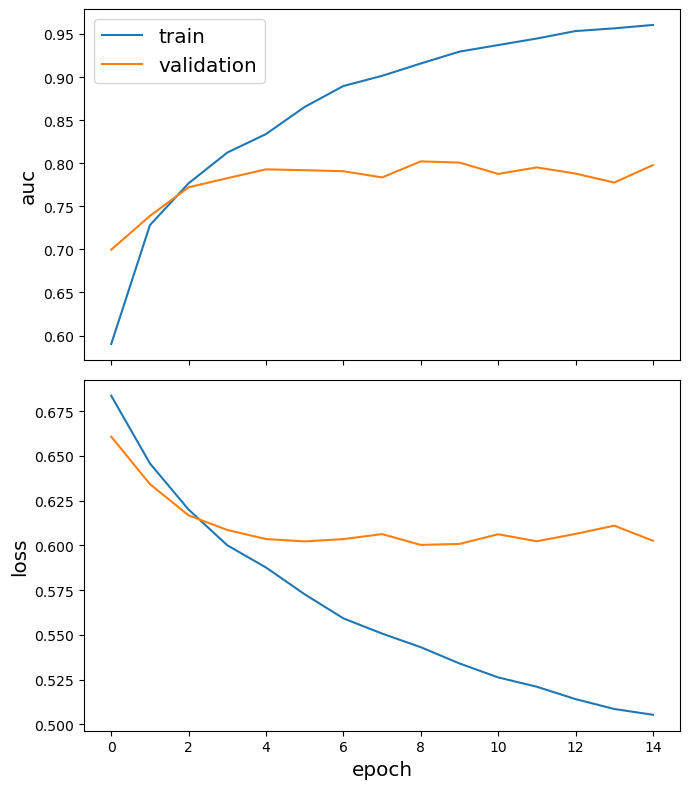

In [18]:
sg.utils.plot_history(history)

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

60/60 [==============================] - 2s 28ms/step - loss: 0.6028 - auc: 0.7976

Train Set Metrics of the trained model:
	loss: 0.4690
	auc: 0.9843

Test Set Metrics of the trained model:
	loss: 0.6028
	auc: 0.7976


In [20]:
edge_ids_test

array([['CC=C(C)C(=O)OC1C(C)OC(OC2C(O)C(C)OC(OC3C(OC4C(OC(CCCCC)CCCCCCCCCC(=O)O)OC(C)C(O)C4O)OC(CO)C(O)C3O)C2OC(=O)C(C)CC)C(O)C1O',
        'Ipomoea orizabensis'],
       ['C=C1CC23CC1(O)CCC2C12CCCC(C)(C(=O)OC1)C2C3C(=O)O',
        'Marah macrocarpa'],
       ['CC(C)c1ccc(C=O)cc1', 'Eucalyptus polyanthemos'],
       ...,
       ['COc1cc(-c2coc3cc(O)c(OC)c(O)c3c2=O)cc(O)c1OC',
        'Mentha x piperita'],
       ['CC1CCC2(C(=O)O)CCC3(C)C(=CCC4C5(C)CCC(O)C(C)(C)C5C(O)CC43C)C2C1(C)O',
        'Plicanthus hirtellus'],
       ['CC1=CC(C)C(=O)CC(O)C(C)=CC(C)CC(C)CCC(C(C)C(=O)O)OC(=O)C(C)C1',
        'Canavalia ensiformis']], dtype=object)

In [21]:
out = model.predict(test_flow)

60/60 [==============================] - 2s 26ms/step


In [22]:
out

array([[0.6112289 ],
       [0.55005836],
       [0.68289256],
       ...,
       [0.42510748],
       [0.65705276],
       [0.36214274]], dtype=float32)

In [23]:
np.mean(out[1500:3000])

0.5762129

In [24]:
np.mean(out[:2000])

0.5818902

In [25]:
min(out)

array([0.28104743], dtype=float32)

In [26]:
max(out)

array([0.7247121], dtype=float32)

In [27]:
x_id =np.array([['C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C',
          'Taxus canadensis'],
               ['C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C',
               'Homo sapiens']])

In [28]:
pred_gen = HinSAGELinkGenerator(G_test, 1, num_samples, head_node_types=["molecule", "species"]).flow(x_id)

KeyError: 'Node ID C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C supplied to generator not found in graph'

In [ ]:
model.predict(pred_gen)

In [ ]:
df_agg[df_agg['structure_smiles_2D'] == 'C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C']